In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from hacktops.data import generate_top_dataset
from hacktops.utils import instance_norm

Retrieve markers in wells for specified top

In [232]:
tops = ['SYLVAIN', 'MARCEL', 'CONRAD']
top_ = tops[1]
df_logs_ = pd.read_parquet("../data/logs.parquet")
df_loc_ = pd.read_parquet("../data/loc.parquet")
df_tops_ = pd.read_parquet("../data/tops.parquet")


# df_logs_ = pd.read_parquet("../testdata/logs_50.parquet")
# df_loc_ = pd.read_parquet("../testdata/loc_50.parquet")
# df_tops_ = pd.read_csv("../testdata/tops_50.csv", index_col=0)

In [233]:

def get_well_marker(top_index: int, df_well: pd.DataFrame, window_len: int, shift: int):

    left_limit = top_index - window_len
    right_limit = top_index + window_len
    window_data = df_well['GR'].loc[left_limit:right_limit]
    window_data = np.array(window_data).reshape(-1)
    # print(top_index, df_well.shape, df_well.index[-1], len(window_data))
    return window_data

WIN_LEN = 30
SHIFT = 1

no_match_count = 0
well_marker = dict()
for well_name in df_tops_.index:
    true_depth = df_tops_.loc[well_name][top_]
    df_well = df_logs_[df_logs_['wellName'] == well_name]
    true_depth_row = df_well[df_well['DEPTH'] == true_depth]
    true_depth_idx = true_depth_row.index
    if true_depth_idx.shape[0] == 1:
        # print(well_name)
        marker = get_well_marker(true_depth_idx.values[0], df_well, WIN_LEN, SHIFT)
        well_marker[well_name] = marker
    else:
        no_match_count += 1
print(f'{no_match_count} wells don\'t match. Markers of {len(well_marker)} wells found. ') 

11 wells don't match. Markers of 589 wells found. 


Visualization

In [234]:
def random_sample_n(X, k):
    samples = random.sample(X, k=k)
    return samples

def avg_window(samples: np.ndarray, normalize:bool = False):
    '''
    normalize: normalize the data or not
    '''
    if normalize:
        normalized = [instance_norm(sample) for sample in samples]
        return np.average(normalized, 0)
    else:
        return np.average(samples, 0)


Window size = 61  GR measures


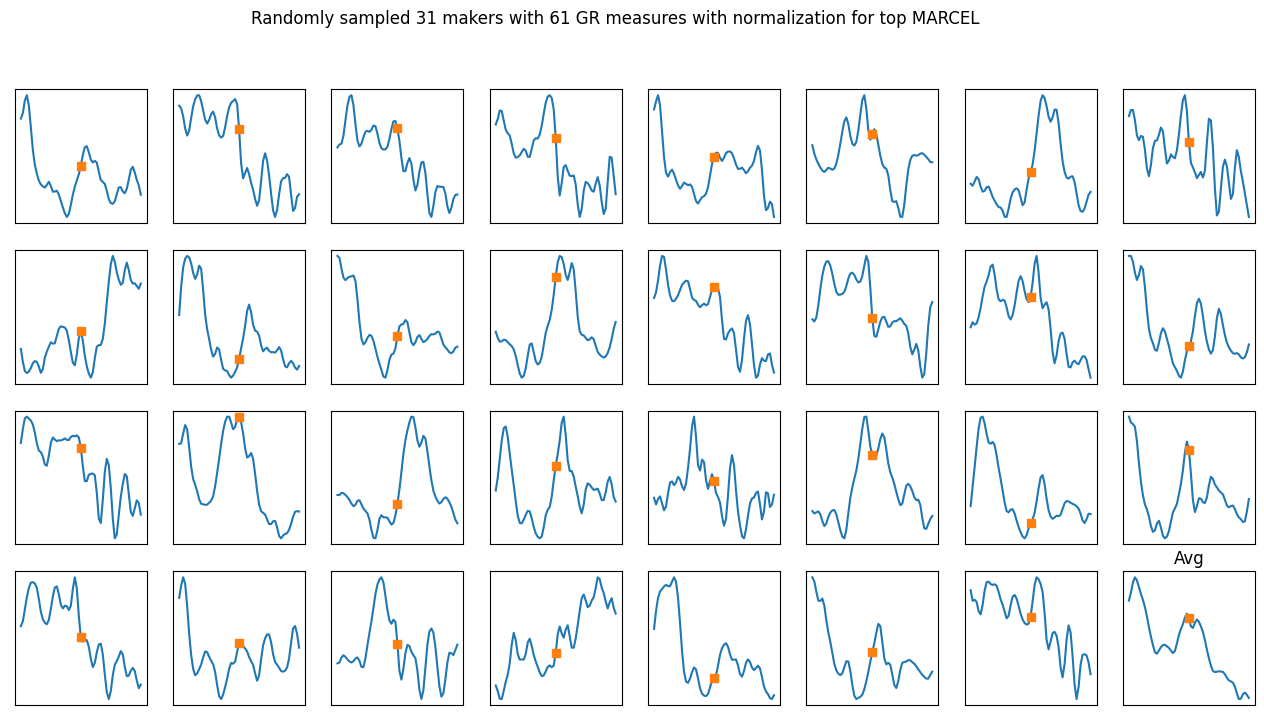

In [240]:
w, h = 4, 8
sample_num = w * h - 1
samples = random_sample_n(list(well_marker.values()), sample_num)
fig, axes = plt.subplots(w, h, figsize=(16,8))
fig.suptitle(f"Randomly sampled {sample_num} makers with {2*WIN_LEN+1} GR measures with normalization for top {top_}")
print("Window size =", 2*WIN_LEN+1, ' GR measures' )
for i, ax in enumerate(axes.flat[:-1]):
    data = samples[i]
    ax.plot(range(len(data)), data)
    ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title('Avg w. norm')

ax = axes.flat[-1]  
data = avg_window(samples[:-2], normalize=True)
ax.plot(range(len(data)), data)
ax.plot([WIN_LEN], [data[WIN_LEN]], 's')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Avg')

plt.show()

Correlation analysis

In [236]:
from dtaidistance import dtw
from scipy.spatial.distance import pdist

In [237]:
dist_m_wo_norm = dtw.distance_matrix_fast(list(well_marker.values()))
dist_m_w_norm = dtw.distance_matrix_fast([instance_norm(marker) for marker in list(well_marker.values())])

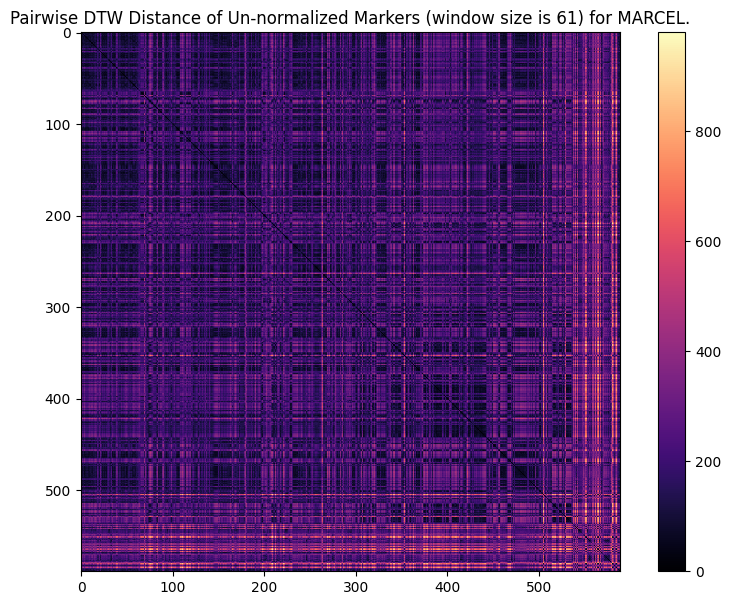

In [238]:
# Heat map
plt.figure(figsize = (10,7))
plt.imshow(dist_m_wo_norm , cmap = 'magma')

plt.title( f"Pairwise DTW Distance of Un-normalized Markers (window size is {2*WIN_LEN+1}) for {top_}." )
plt.colorbar()
plt.savefig(fname='dtw_distance_matrix/' + f'{top_}-{WIN_LEN}-{df_tops_.shape[0]}-unnormalized.png')
plt.show()

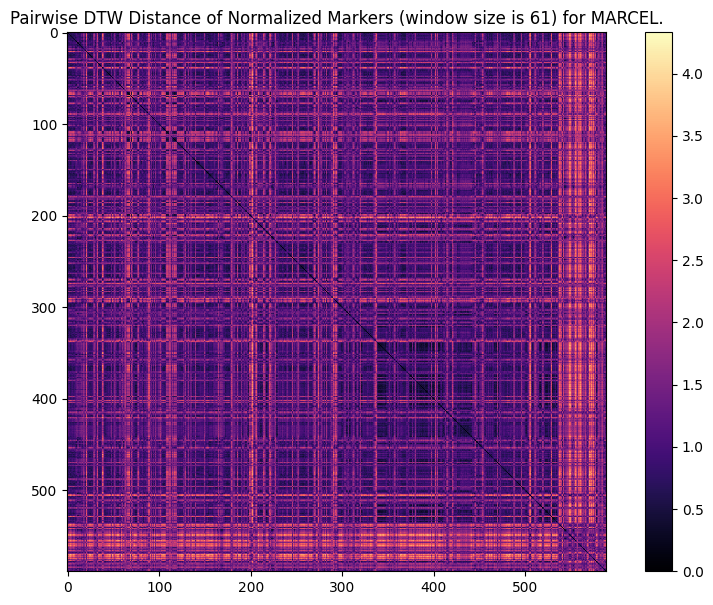

In [239]:
# Heat map
plt.figure(figsize = (10,7))
plt.imshow(dist_m_w_norm , cmap = 'magma')

# plt.title( f"Pairwise DTW Distance of Normalized Markers for {top_}" )
plt.title( f"Pairwise DTW Distance of Normalized Markers (window size is {2*WIN_LEN+1}) for {top_}." )
plt.colorbar()
plt.savefig(fname='dtw_distance_matrix/' + f'{top_}-{WIN_LEN}-{df_tops_.shape[0]}-normalized.png')
plt.show()
# plt.savefig(fname = f'dtw_distance_matrix/{top_}-{df_tops_.shape[0]}-normalized.png')

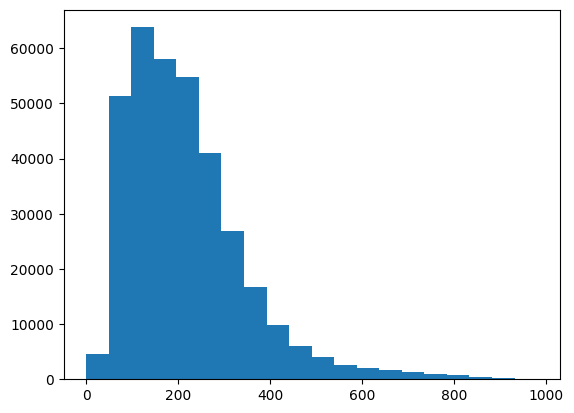

In [250]:
plt.hist(dist_m_wo_norm.flatten(), bins=20)
plt.show()

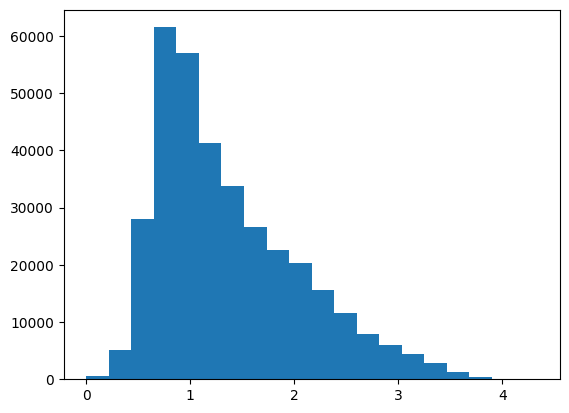

In [249]:
plt.hist(dist_m_w_norm.flatten(), bins=20)
plt.show()

Next